In [16]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
from scipy.interpolate import splrep, BSpline
from scipy.optimize import minimize

from src.preprocess import stratify5
from src.aggregate_features import generate_lrtt_features, generate_maf_features
from src.read_data import load_reference_data2

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

#https://people.stat.sc.edu/hansont/stat740/Pspline.pdf

# 1 - Prepare Data

In [36]:
#LOAD DATASETS
phylo = pd.read_csv('./data/derived/imputed_phylo_data.csv')
maf = pd.read_csv('./data/derived/imputed_MAF_data2.csv')
ambig = pd.read_csv('./data/derived/ambiguity/ambiguity_genes.csv')

#ADD TSI CATEGORIES
phylo = stratify5(phylo)
maf = stratify5(maf)

#sort by ID and coordinate
phylo = phylo.sort_values(by=['RENAME_ID', 'xcoord'])
maf = maf.sort_values(by=['RENAME_ID', 'Window_Centre'])

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_53477/1668579925.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  phylo = pd.read_csv('./data/derived/imputed_phylo_data.csv')


In [37]:
#ENCODE STRATA IN FIVE CLASSES
tsi_order = ['0m-6m', '6m-12m', '12m-24m', '2y-4y', '4y+']
ordinal_encoder = OrdinalEncoder(categories=[tsi_order])
phylo['TSI_encoded'] = ordinal_encoder.fit_transform(phylo[['TSI_category']])
maf['TSI_encoded'] = ordinal_encoder.fit_transform(maf[['TSI_category']])

#FIND UNIQUE IDS   
unique_ids = phylo['RENAME_ID'].unique()
#SPLIT BASED ON IDS
train_ids, test_ids = train_test_split(unique_ids, test_size=0.25, random_state=42)

#TRAIN AND TEST DATASETS
train_phylo = phylo[phylo['RENAME_ID'].isin(train_ids)]
test_phylo = phylo[phylo['RENAME_ID'].isin(test_ids)]
train_maf = maf[maf['RENAME_ID'].isin(train_ids)]
test_maf = maf[maf['RENAME_ID'].isin(test_ids)]
train_ambig = ambig[ambig['RENAME_ID'].isin(train_ids)]
test_ambig = ambig[ambig['RENAME_ID'].isin(test_ids)]

# 2 - P-SPLINE SMOOTHING

In [38]:
def pspline_penalized_smoothing(df, x, y, num_knots, lambda_penalty):
    """
    Fit a penalized B-spline (P-spline) to the data.

    Parameters:
    df : pandas.DataFrame
        DataFrame containing the data.
    x : str
        Name of the column for the predictor variable.
    y : str
        Name of the column for the response variable.
    num_knots : int
        Number of knots to use for the spline.
    lambda_penalty : float
        Smoothing parameter for penalization.

    Returns:
    smoothed_values : np.ndarray
        Smoothed values of the response variable.
    c_opt : np.ndarray
        Optimized coefficients of the B-spline.
    """
    # Sort the data by the predictor variable
    df = df.sort_values(by=x)
    
    # Check for NaN values and constant values
    if df[x].isna().any() or df[y].isna().any():
        print(f"NaN values found in group {df['RENAME_ID'].iloc[0]}")
        return np.full(df.shape[0], np.nan), np.full(num_knots + 3, np.nan)
    if df[x].nunique() == 1 or df[y].nunique() == 1:
        print(f"Constant values found in group {df['RENAME_ID'].iloc[0]}")
        return np.full(df.shape[0], np.nan), np.full(num_knots + 3, np.nan)
    
    # Extract the values of the predictor and response variables
    x_vals = df[x].values
    y_vals = df[y].values
    
    # Define the knots uniformly over the range of the predictor variable
    knots = np.linspace(x_vals.min(), x_vals.max(), num_knots)[1:-1]
    
    # Initial spline fitting to obtain knots and coefficients
    t, c, k = splrep(x_vals, y_vals, t=knots, k=3)
    
    # Define the objective function for penalization
    def objective(c):
        spline = BSpline(t, c, k, extrapolate=False)
        residuals = y_vals - spline(x_vals)
        penalty = lambda_penalty * np.sum(np.diff(c, 2)**2)
        return np.sum(residuals**2) + penalty
    
    # Optimize the spline coefficients with the penalty term
    result = minimize(objective, c)
    c_opt = result.x
    
    # Generate the smoothed values using the optimized coefficients
    bspline = BSpline(t, c_opt, k, extrapolate=False)
    smoothed_values = bspline(x_vals)
    
    return smoothed_values, c_opt

def apply_pspline_smoothing(df, x, y, num_knots, lambda_penalty):
    """
    Apply P-spline smoothing to a grouped DataFrame.

    Parameters:
    df : pandas.DataFrame
        DataFrame containing the data.
    x : str
        Name of the column for the predictor variable.
    y : str
        Name of the column for the response variable.
    num_knots : int
        Number of knots to use for the spline.
    lambda_penalty : float
        Smoothing parameter for penalization.

    Returns:
    smoothed_values : pd.Series
        Series of smoothed values of the response variable.
    coefficients : pd.DataFrame
        DataFrame of optimized coefficients of the B-spline for each group.
    """
    # Apply the P-spline smoothing function to each group in the DataFrame
    smoothed_values = df.groupby('RENAME_ID', group_keys=False).apply(
        lambda group: pd.Series(pspline_penalized_smoothing(group, x, y, num_knots, lambda_penalty)[0], index=group.index)
    )
    coefficients = df.groupby('RENAME_ID').apply(
        lambda group: pd.Series(pspline_penalized_smoothing(group, x, y, num_knots, lambda_penalty)[1])
    )
    
    return smoothed_values, coefficients


In [39]:
lambda_penalty = 1.0

# Apply P-spline smoothing
smoothed_lrtt_train, coefficients_lrtt_train = apply_pspline_smoothing(train_phylo, 'xcoord', 'normalised.largest.rtt', 12, lambda_penalty)
smoothed_maf12c_train, coefficients_maf12c_train = apply_pspline_smoothing(train_maf, 'Window_Centre', 'MAF12c_Mean', 20, lambda_penalty)
smoothed_maf3c_train, coefficients_maf3c_train = apply_pspline_smoothing(train_maf, 'Window_Centre', 'MAF3c_Mean', 4, lambda_penalty)

smoothed_lrtt_test, coefficients_lrtt_test = apply_pspline_smoothing(test_phylo, 'xcoord', 'normalised.largest.rtt', 12, lambda_penalty)
smoothed_maf12c_test, coefficients_maf12c_test = apply_pspline_smoothing(test_maf, 'Window_Centre', 'MAF12c_Mean', 20, lambda_penalty)
smoothed_maf3c_test, coefficients_maf3c_test = apply_pspline_smoothing(test_maf, 'Window_Centre', 'MAF3c_Mean', 4, lambda_penalty)

# Adding smoothed values to the DataFrame
train_phylo['smoothed_lrtt'] = smoothed_lrtt_train
train_maf['smoothed_maf12c'] = smoothed_maf12c_train
train_maf['smoothed_maf3c'] = smoothed_maf3c_train

test_phylo['smoothed_lrtt'] = smoothed_lrtt_test
test_maf['smoothed_maf12c'] = smoothed_maf12c_test
test_maf['smoothed_maf3c'] = smoothed_maf3c_test

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_53477/1406133302.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  smoothed_values = df.groupby('RENAME_ID', group_keys=False).apply(
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_53477/1406133302.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  coefficients = df.groupby('RENAME_ID').apply(
/var/folders/rt/3hw_n0v124vg8h2q8kwnx31

## Plot

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_53477/2835423363.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = train_phylo.groupby(['TSI_category', 'xcoord']).agg({
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_53477/2835423363.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values_maf = train_maf.groupby(['TSI_category', 'Window_Centre']).agg({


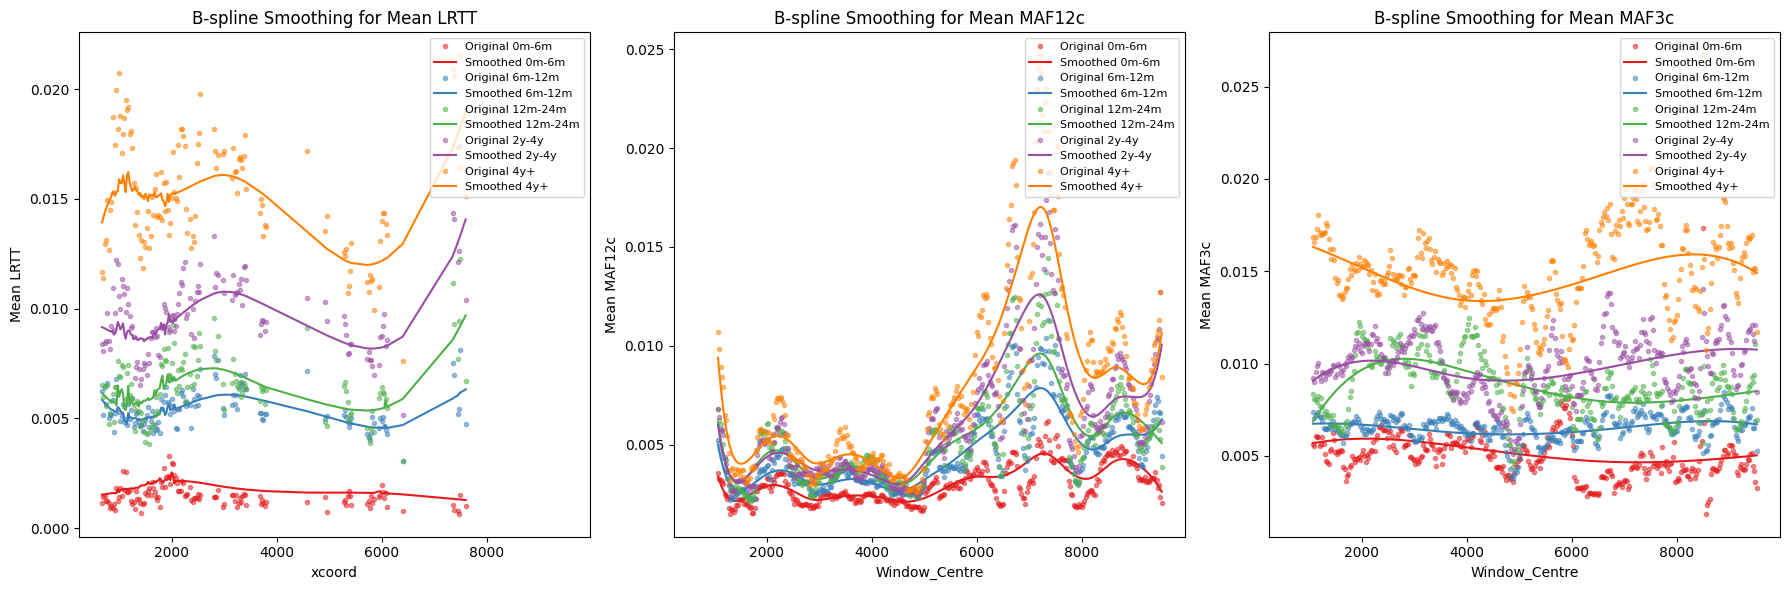

In [23]:
mean_values = train_phylo.groupby(['TSI_category', 'xcoord']).agg({
    'normalised.largest.rtt': 'mean',
    'smoothed_lrtt': 'mean'
}).reset_index()

mean_values_maf = train_maf.groupby(['TSI_category', 'Window_Centre']).agg({
    'MAF12c_Mean': 'mean',
    'smoothed_maf12c': 'mean',
    'MAF3c_Mean': 'mean',
    'smoothed_maf3c': 'mean'
}).reset_index()

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
palette = sns.color_palette("Set1", n_colors=5)

# Plot for normalised.largest.rtt
for i, category in enumerate(mean_values['TSI_category'].unique()):
    category_df = mean_values[mean_values['TSI_category'] == category]
    axs[0].plot(category_df['xcoord'], category_df['normalised.largest.rtt'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    axs[0].plot(category_df['xcoord'], category_df['smoothed_lrtt'], '-', label=f'Smoothed {category}', color=palette[i])

axs[0].set_xlabel('xcoord')
axs[0].set_ylabel('Mean LRTT')
axs[0].legend(loc='upper right', fontsize=8)
axs[0].set_title('B-spline Smoothing for Mean LRTT')

# Plot for MAF12c_Mean
for i, category in enumerate(mean_values_maf['TSI_category'].unique()):
    category_df = mean_values_maf[mean_values_maf['TSI_category'] == category]
    axs[1].plot(category_df['Window_Centre'], category_df['MAF12c_Mean'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    axs[1].plot(category_df['Window_Centre'], category_df['smoothed_maf12c'], '-', label=f'Smoothed {category}', color=palette[i])

axs[1].set_xlabel('Window_Centre')
axs[1].set_ylabel('Mean MAF12c')
axs[1].legend(loc='upper right', fontsize=8)
axs[1].set_title('B-spline Smoothing for Mean MAF12c')

# Plot for MAF3c_Mean
for i, category in enumerate(mean_values_maf['TSI_category'].unique()):
    category_df = mean_values_maf[mean_values_maf['TSI_category'] == category]
    axs[2].plot(category_df['Window_Centre'], category_df['MAF3c_Mean'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    axs[2].plot(category_df['Window_Centre'], category_df['smoothed_maf3c'], '-', label=f'Smoothed {category}', color=palette[i])

axs[2].set_xlabel('Window_Centre')
axs[2].set_ylabel('Mean MAF3c')
axs[2].legend(loc='upper right', fontsize=8)
axs[2].set_title('B-spline Smoothing for Mean MAF3c')

plt.tight_layout()
plt.show()

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_53477/2835423363.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = train_phylo.groupby(['TSI_category', 'xcoord']).agg({
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_53477/2835423363.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values_maf = train_maf.groupby(['TSI_category', 'Window_Centre']).agg({


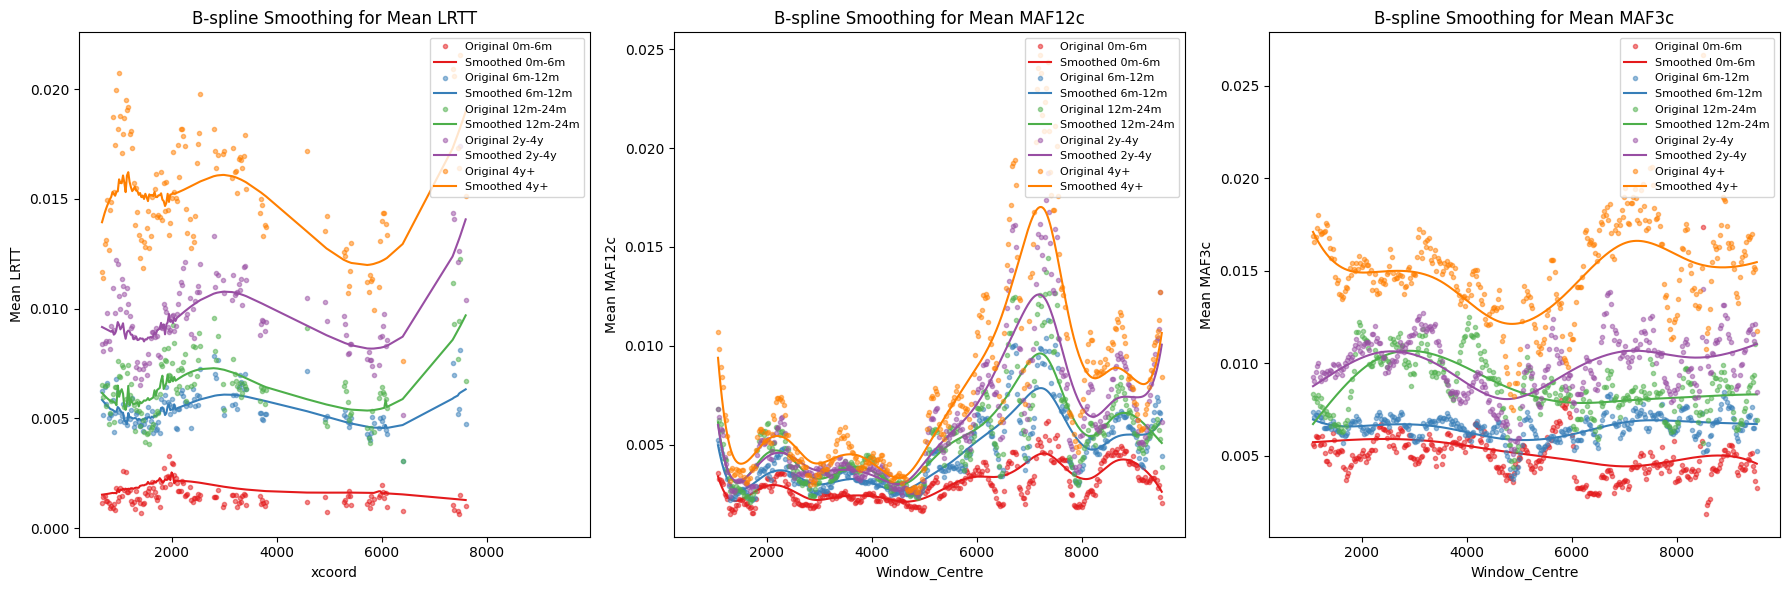

In [57]:
mean_values = train_phylo.groupby(['TSI_category', 'xcoord']).agg({
    'normalised.largest.rtt': 'mean',
    'smoothed_lrtt': 'mean'
}).reset_index()

mean_values_maf = train_maf.groupby(['TSI_category', 'Window_Centre']).agg({
    'MAF12c_Mean': 'mean',
    'smoothed_maf12c': 'mean',
    'MAF3c_Mean': 'mean',
    'smoothed_maf3c': 'mean'
}).reset_index()

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
palette = sns.color_palette("Set1", n_colors=5)

# Plot for normalised.largest.rtt
for i, category in enumerate(mean_values['TSI_category'].unique()):
    category_df = mean_values[mean_values['TSI_category'] == category]
    axs[0].plot(category_df['xcoord'], category_df['normalised.largest.rtt'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    axs[0].plot(category_df['xcoord'], category_df['smoothed_lrtt'], '-', label=f'Smoothed {category}', color=palette[i])

axs[0].set_xlabel('xcoord')
axs[0].set_ylabel('Mean LRTT')
axs[0].legend(loc='upper right', fontsize=8)
axs[0].set_title('B-spline Smoothing for Mean LRTT')

# Plot for MAF12c_Mean
for i, category in enumerate(mean_values_maf['TSI_category'].unique()):
    category_df = mean_values_maf[mean_values_maf['TSI_category'] == category]
    axs[1].plot(category_df['Window_Centre'], category_df['MAF12c_Mean'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    axs[1].plot(category_df['Window_Centre'], category_df['smoothed_maf12c'], '-', label=f'Smoothed {category}', color=palette[i])

axs[1].set_xlabel('Window_Centre')
axs[1].set_ylabel('Mean MAF12c')
axs[1].legend(loc='upper right', fontsize=8)
axs[1].set_title('B-spline Smoothing for Mean MAF12c')

# Plot for MAF3c_Mean
for i, category in enumerate(mean_values_maf['TSI_category'].unique()):
    category_df = mean_values_maf[mean_values_maf['TSI_category'] == category]
    axs[2].plot(category_df['Window_Centre'], category_df['MAF3c_Mean'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    axs[2].plot(category_df['Window_Centre'], category_df['smoothed_maf3c'], '-', label=f'Smoothed {category}', color=palette[i])

axs[2].set_xlabel('Window_Centre')
axs[2].set_ylabel('Mean MAF3c')
axs[2].legend(loc='upper right', fontsize=8)
axs[2].set_title('B-spline Smoothing for Mean MAF3c')

plt.tight_layout()
plt.show()

## agreggating features

In [51]:
first_second_codon_pos, third_codon_pos, gag, pol, gp120, gp41 = load_reference_data2('./data/')

# Generate aggregated features for train and test datasets separately
train_phylo_features = generate_lrtt_features(train_phylo, gag, pol, gp120, gp41, feature='smoothed_lrtt')
test_phylo_features = generate_lrtt_features(test_phylo, gag, pol, gp120, gp41, feature='smoothed_lrtt')

train_maf_features = generate_maf_features(train_maf, gag, pol, gp120, gp41, feature_12c = 'smoothed_maf12c', feature_3c= 'smoothed_maf3c')
test_maf_features = generate_maf_features(test_maf, gag, pol, gp120, gp41, feature_12c = 'smoothed_maf12c', feature_3c= 'smoothed_maf3c')

# Merge the aggregated features
train_features = pd.merge(train_phylo_features, train_maf_features, on=['RENAME_ID', 'TSI_days'], how = 'inner')
test_features = pd.merge(test_phylo_features, test_maf_features, on=['RENAME_ID', 'TSI_days'], how = 'inner')

In [52]:
# Finalize the features
train_features = stratify5(train_features)
test_features = stratify5(test_features)

## Adding Meta Features: Coefficients

In [53]:
def expand_coefficients(df, coeffs, prefix):
    """
    Expand spline coefficients into the DataFrame as new features.

    Parameters:
    df : pandas.DataFrame
        DataFrame containing the original data.
    coeffs : pandas.DataFrame
        DataFrame containing the spline coefficients.
    prefix : str
        Prefix for the new coefficient columns.

    Returns:
    df : pandas.DataFrame
        DataFrame with the expanded coefficient features.
    """
    coeffs_df = coeffs.reset_index()
    coeffs_df.columns = [f'{prefix}_coeff_{col}' if col != 'RENAME_ID' else 'RENAME_ID' for col in coeffs_df.columns]
    coeffs_df = coeffs_df.iloc[:, :-4]  # Drop the last four columns
    return pd.merge(df, coeffs_df, on='RENAME_ID', how='left')

train_features = expand_coefficients(train_features, coefficients_lrtt_train, 'lrtt')
train_features = expand_coefficients(train_features, coefficients_maf12c_train, 'maf12c')
train_features = expand_coefficients(train_features, coefficients_maf3c_train, 'maf3c')

test_features = expand_coefficients(test_features, coefficients_lrtt_test, 'lrtt')
test_features = expand_coefficients(test_features, coefficients_maf12c_test, 'maf12c')
test_features = expand_coefficients(test_features, coefficients_maf3c_test, 'maf3c')

## Add Ambiguity Data

In [54]:
# Merge ambiguity data
train_features = pd.merge(train_features, train_ambig[['RENAME_ID', 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig']], on='RENAME_ID', how='inner')
test_features = pd.merge(test_features, test_ambig[['RENAME_ID', 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig']], on='RENAME_ID', how='inner')

In [55]:
train_features.to_csv('./data/derived/feature_selection/pspline_training_data.csv', header = True)
test_features.to_csv('./data/derived/feature_selection/pspline_test_data.csv', header = True)